## Appendix：ラット自由行動下の軌跡のシミュレーション

([Raudies & Hasselmo, PLoS Comput Biol. 2012](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002553)) の擬似コードに従って作成．

In [1]:
using PyPlot, Random, Distributions

In [2]:
ROOM_LEN = 2.2        # Width and height of environment (meters)
PERIMETER_DIST = 0.03 # Perimeter region distance to walls (meters)
σv = 0.13            # Forward velocity Rayleigh distribution scale (m/sec)
μϕ = 0.0            # Rotation velocity Gaussian distribution mean (rad/sec)
σϕ = (330 / 360) * 2π # Rotation velocity Gaussian distribution standard deviation (rad/sec)
Δt = 0.02;           # Simulation-step time increment (seconds)

In [3]:
wrap(x) = mod(x, 2π); # limit 0~2π angle

Juliaの余りの関数は `rem(x, y)` と `mod(x, y)`がある。Juliaの`x % y`は`rem`と同じだが、Pythonの場合は`mod`と同じなので、注意。

In [4]:
println("% : ", -1 % 2, ", rem : ", rem(-1, 2), ", mod : ", mod(-1, 2))

% : -1, rem : -1, mod : 1


In [5]:
# for square room of size ROOM_LEN x ROOM_LEN
# d:dist, a:angle
function minDistAngleRectangle(pos, θ)
    if pos[1] < PERIMETER_DIST
        dWall, aWall = pos[1], θ + π
    elseif pos[2] < PERIMETER_DIST
        dWall, aWall = pos[2], θ + 1.5π
    elseif pos[1] > ROOM_LEN - PERIMETER_DIST
        dWall, aWall = ROOM_LEN - pos[1], θ
    elseif pos[2] > ROOM_LEN - PERIMETER_DIST
        dWall, aWall = ROOM_LEN - pos[2], θ + 0.5π
    else
        dWall, aWall = 3.0, 0.0
    end
    aWall = wrap(aWall)
    return dWall, aWall
end;

In [9]:
# for square room of size ROOM_LEN x ROOM_LEN
# d:dist, a:angle
function minDistAngleCircle(pos, θ)
    dCenter = sqrt(pos[1]^2+pos[2]^2)
    if dCenter < PERIMETER_DIST
        dWall, aWall = ROOM_LEN/2 - dCenter, θ
    else
        dWall, aWall = 3.0, 0.0
    end
    aWall = wrap(aWall)
    return dWall, aWall
end;

In [10]:
function generateRatTrajectory(num_steps)
    # store arrays
    Position = zeros(num_steps, 2)
    Velocity = zeros(num_steps, 2)
    Speed = zeros(num_steps) # Forward speed
    θ = zeros(num_steps) # head direction
    Ω = zeros(num_steps) # rotation velocity

    # initial
    ω = 0.  # angular velocity
    θ[1] = rand() * 2π
    Speed[1] = 0.
    Position[1, :] = clamp.(rand(2) * ROOM_LEN, -0.1, ROOM_LEN-0.1)
    Velocity[1, :] =  Speed[1] * [sin(θ[1]), cos(θ[1])]
    
    # Iteration of trajectory
    for i in 1:num_steps-1
        dWall, aWall = minDistAngleCircle(pos, θ[i])
        #dWall, aWall = minDistAngleSquare(pos, θ)
        if (dWall < PERIMETER_DIST) && (0 < aWall < π)
            θ[i+1] = wrap(sign(aWall) * (π - abs(aWall)) + μϕ + randn()*σϕ) # turn
            Speed[i+1] = Speed[i] - 0.5* (Speed[i] - 5.0) # slow down
        else
            Speed[i+1] = rand(Rayleigh(σv))
            ω = μϕ + randn()*σϕ
        end
        Velocity[i+1, :] = Speed[i+1] * [sin(θ[i+1]), cos(θ[i+1])]
        Position[i+1, :] = Position[i, :] + Velocity[i+1, :] * Δt

        # update pos, angle
        θ[i+1] = wrap(θ[i+1] + ω * Δt)

        # store in array
        Ω[i] = ω
    end
        
    # inputs
    rot_vel = [sin.(Ω), cos.(Ω)]'
    return initPos, initθ, Position, Velocity, θ, rot_vel, Speed
end

generateRatTrajectory (generic function with 1 method)

In [11]:
num_timesteps = 20000
initPos, initθ, Position, Velocity, Θ, rot_vel, ForwardSpeed =  generateRatTrajectory(num_timesteps);

黒点から始まり、赤点に終わる。

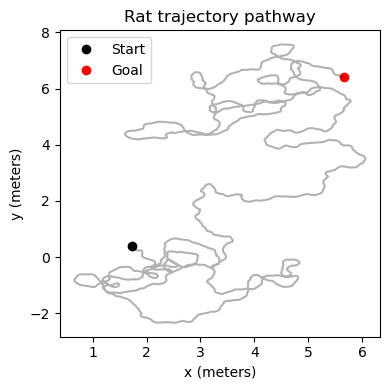

In [13]:
figure(figsize=(4, 4))
title("Rat trajectory pathway")
xlabel("x (meters)"); ylabel("y (meters)")
#xlim((0, ROOM_LEN+0.01)); ylim((0, ROOM_LEN))
plot(initPos[1], initPos[2], "ko", label="Start")
plot(Position[end, 1], Position[end, 2], "ro", label="Goal")
plot(Position[:, 1], Position[:, 2], color="k", alpha=0.3)
legend()
tight_layout()

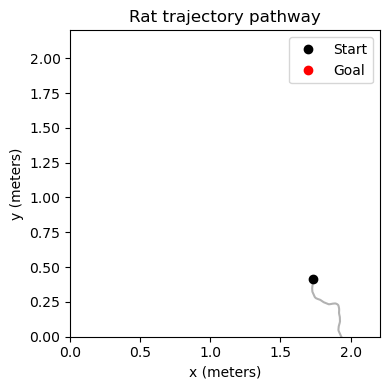

In [12]:
figure(figsize=(4, 4))
title("Rat trajectory pathway")
xlabel("x (meters)"); ylabel("y (meters)")
xlim((0, ROOM_LEN+0.01)); ylim((0, ROOM_LEN))
plot(initPos[1], initPos[2], "ko", label="Start")
plot(Position[end, 1], Position[end, 2], "ro", label="Goal")
plot(Position[:, 1], Position[:, 2], color="k", alpha=0.3)
legend()
tight_layout()